In [53]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

In [54]:
device

'cuda'

In [55]:
dataset = datasets.ImageFolder(root="/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0")

dataset.classes

['all', 'hem']

In [56]:
dataset = datasets.ImageFolder(root="/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0")


In [57]:
len(dataset)

3527

In [58]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor()
])

In [59]:
root_dir_0 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0"
root_dir_1 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1"
root_dir_2 = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2"

In [60]:
dataset_0 = datasets.ImageFolder(root=root_dir_0, transform=transform)
dataset_1 = datasets.ImageFolder(root=root_dir_1, transform=transform)
dataset_2 = datasets.ImageFolder(root=root_dir_2, transform=transform)

data = ConcatDataset([dataset_0, dataset_1, dataset_2])

class_names = dataset_0.classes

In [61]:
# list
class_names

['all', 'hem']

In [62]:
from torch.utils.data import random_split

train_ratio = 0.8


train_data, test_data = random_split(data, [train_ratio, 1-train_ratio])

In [63]:
len(train_data), len(test_data)

(8529, 2132)

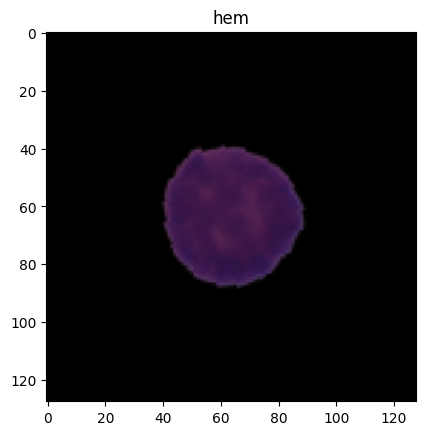

In [64]:
import numpy as np
img, label = train_data[3300]
image = np.array(img)
# pytorch order -> matplotlib order 
image = image.transpose((1, 2, 0))
plt.title(class_names[label])
plt.imshow(image)

In [65]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

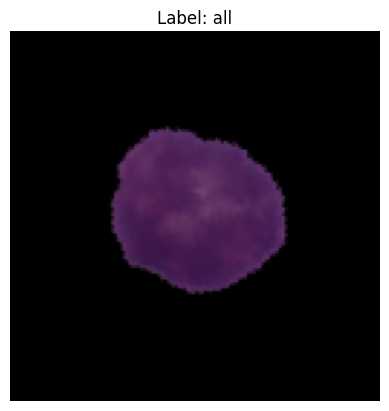

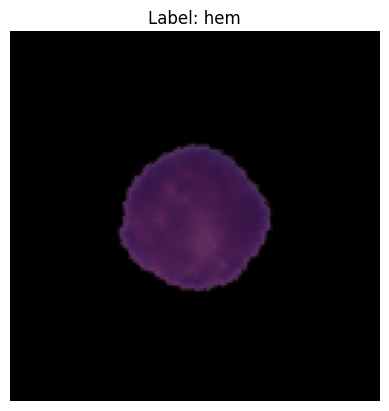

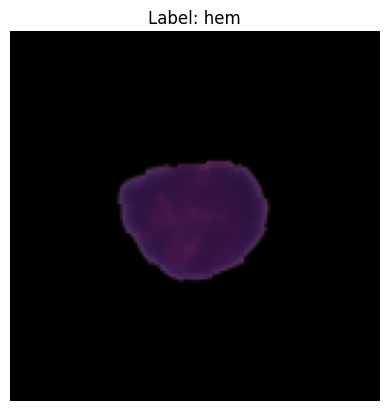

In [66]:
for i in range(3): 
    img, label = train_data[i]
    
    img = img.numpy()

   
    img = img.transpose((1, 2, 0))

    plt.imshow(img)
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')
    plt.show()

In [67]:
train_data[0][0].shape

torch.Size([3, 128, 128])

In [68]:
# Вихідна ширина = (вхідна ширина - фільтрована ширина + 1) // крок
# Вихідна висота = (вхідна висота - висота фільтра + 1) // крок

In [69]:
from torch import nn 
import torch.nn.functional as F
import numpy as np

class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()
#         128, 128, 3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
#         126, 126, 6
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
#          124, 124, 12
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#          62, 62, 12
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
#          60, 60, 24
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3)
#          58, 58, 48
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#          29, 29, 48
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=2)
#          28, 28, 48
        self.conv6 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3)
#          26, 26, 48
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
#          13, 13, 48
        self.conv7 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=2)
#          12, 12, 48
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
#           6, 6, 48
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
#           3, 3, 48 
        self.conv8 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=2)
#           2, 2, 48 
    
#         192
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=192, out_features=150)
        self.bnorm1 = nn.BatchNorm1d(num_features=150)
        self.linear2 = nn.Linear(in_features=150, out_features=100)
        self.drop1 = nn.Dropout(0.3)
        self.linear3 = nn.Linear(in_features=100, out_features=60)
        self.linear4 = nn.Linear(in_features=60, out_features=30)
        self.linear5 = nn.Linear(in_features=30, out_features=18)
        self.linear6 = nn.Linear(in_features=18, out_features=10)
        self.linear7 = nn.Linear(in_features=10, out_features=4)
        self.linear8 = nn.Linear(in_features=4, out_features=1)
        
        

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = F.relu(out)
        out = self.conv5(out)
        out = F.relu(out)
        out = self.conv6(out)
        out = F.relu(out)
        out = self.pool3(out)
        out = F.relu(out)
        out = self.conv7(out)
        out = F.relu(out)
        out = self.pool4(out)
        out = F.relu(out)
        out = self.pool5(out)
        out = F.relu(out)
        out = self.conv8(out)
        
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.bnorm1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.drop1(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        out = F.relu(out)
        out = self.linear7(out)
        out = F.relu(out)
        out = self.linear8(out)
        out = F.sigmoid(out)
        
    
        
        return out 
    
    def predict(self, X, device=device):
        X = torch.FloatTensor(X).to(device)
        with torch.no_grad():
            y_pred = self.forward(X)
        return y_pred.cpu().numpy().squeeze()
 
    
    

model = ConvNetwork()
model.to(device)
     
       
        
    

ConvNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(48, 48, kernel_size=(2, 2), stride=(1, 1))
  (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(48, 48, kernel_size=(2, 2), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv8): Conv2d(48, 48, kernel_size=(2, 2), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_fea

In [70]:
model

ConvNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(48, 48, kernel_size=(2, 2), stride=(1, 1))
  (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(48, 48, kernel_size=(2, 2), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv8): Conv2d(48, 48, kernel_size=(2, 2), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_fea

In [71]:
!pip install -q torchsummary

In [72]:
from torchsummary import summary
model.to(device)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 126, 126]             168
            Conv2d-2         [-1, 12, 124, 124]             660
         MaxPool2d-3           [-1, 12, 62, 62]               0
            Conv2d-4           [-1, 24, 60, 60]           2,616
            Conv2d-5           [-1, 48, 58, 58]          10,416
         MaxPool2d-6           [-1, 48, 29, 29]               0
            Conv2d-7           [-1, 48, 28, 28]           9,264
            Conv2d-8           [-1, 48, 26, 26]          20,784
         MaxPool2d-9           [-1, 48, 13, 13]               0
           Conv2d-10           [-1, 48, 12, 12]           9,264
        MaxPool2d-11             [-1, 48, 6, 6]               0
        MaxPool2d-12             [-1, 48, 3, 3]               0
           Conv2d-13             [-1, 48, 2, 2]           9,264
          Flatten-14                  [

In [83]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y = batch[1].to(device).float().unsqueeze(1)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [74]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [79]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [84]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='binary')

train() called: model=ConvNetwork, opt=Adam(lr=0.001000), epochs=20, device=cuda



ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1]))